In [2]:
from statsmodels.tsa.statespace.structural import UnobservedComponents
import statsmodels.api as sm
import numpy as np 
import pandas as pd
import plotly.express as px


https://www.statsmodels.org/devel/examples/notebooks/generated/statespace_structural_harvey_jaeger.html

https://medium.com/analytics-vidhya/tsa-ucm-python-5fde69d42e28

In [4]:

data = sm.datasets.macrodata.load_pandas().data
data.index = pd.date_range(start = '1959', freq='Q', periods=len(data))
data = data.drop(columns = ['year', 'quarter'])
data = data[['realgdp', 'realcons']]
data

,realgdp,realcons
1959-03-31,2710.349,1707.4
1959-06-30,2778.801,1733.7
1959-09-30,2775.488,1751.8
1959-12-31,2785.204,1753.7
1960-03-31,2847.699,1770.5
...,...,...
2008-09-30,13324.600,9267.7
2008-12-31,13141.920,9195.3
2009-03-31,12925.410,9209.2
2009-06-30,12901.504,9189.0


In [5]:
fig = px.line(data)
fig.update_layout(title='Macrodata',
                   xaxis_title='Quarter',
                   yaxis_title='USD')
fig.show()

In [6]:
help(sm.tsa.UnobservedComponents)

Help on class UnobservedComponents in module statsmodels.tsa.statespace.structural:

class UnobservedComponents(statsmodels.tsa.statespace.mlemodel.MLEModel)
 |  UnobservedComponents(endog, level=False, trend=False, seasonal=None, freq_seasonal=None, cycle=False, autoregressive=None, exog=None, irregular=False, stochastic_level=False, stochastic_trend=False, stochastic_seasonal=True, stochastic_freq_seasonal=None, stochastic_cycle=False, damped_cycle=False, cycle_period_bounds=None, mle_regression=True, use_exact_diffuse=False, **kwargs)
 |  
 |  Univariate unobserved components time series model
 |  
 |  These are also known as structural time series models, and decompose a
 |  (univariate) time series into trend, seasonal, cyclical, and irregular
 |  components.
 |  
 |  Parameters
 |  ----------
 |  
 |  level : {bool, str}, optional
 |      Whether or not to include a level component. Default is False. Can also
 |      be a string specification of the level / trend component; see N

In [18]:
# Model specifications

# Unrestricted model, using string specification
unrestricted_model = {
    'level': 'local linear trend', 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': True
}

# Unrestricted model, setting components directly
# This is an equivalent, but less convenient, way to specify a
# local linear trend model with a stochastic damped cycle:
# unrestricted_model = {
#     'irregular': True, 'level': True, 'stochastic_level': True, 'trend': True, 'stochastic_trend': True,
#     'cycle': True, 'damped_cycle': True, 'stochastic_cycle': True
# }

# The restricted model forces a smooth trend
restricted_model = {
    'level': 'smooth trend', 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': True
}

# Restricted model, setting components directly
# This is an equivalent, but less convenient, way to specify a
# smooth trend model with a stochastic damped cycle. Notice
# that the difference from the local linear trend model is that
# `stochastic_level=False` here.
# unrestricted_model = {
#     'irregular': True, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': True,
#     'cycle': True, 'damped_cycle': True, 'stochastic_cycle': True
# }

In [19]:
# Output
ur_mod = sm.tsa.UnobservedComponents(data['realgdp'], **unrestricted_model)
ur_res = ur_mod.fit(method='powell', disp=False)

# Output
r_mod = sm.tsa.UnobservedComponents(data['realgdp'], **restricted_model)
r_res = r_mod.fit(method='powell', disp=False)

In [20]:
print(ur_res.summary())

                            Unobserved Components Results                            
Dep. Variable:                       realgdp   No. Observations:                  203
Model:                    local linear trend   Log Likelihood               -1083.446
                   + damped stochastic cycle   AIC                           2178.892
Date:                       Tue, 01 Dec 2020   BIC                           2198.652
Time:                               10:02:57   HQIC                          2186.889
Sample:                           03-31-1959                                         
                                - 09-30-2009                                         
Covariance Type:                         opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular     0.0001    248.595   5.13e-07      1

In [21]:
print(r_res.summary())

                            Unobserved Components Results                            
Dep. Variable:                       realgdp   No. Observations:                  203
Model:                          smooth trend   Log Likelihood               -1083.282
                   + damped stochastic cycle   AIC                           2176.565
Date:                       Tue, 01 Dec 2020   BIC                           2193.031
Time:                               10:02:57   HQIC                          2183.229
Sample:                           03-31-1959                                         
                                - 09-30-2009                                         
Covariance Type:                         opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular     0.0166    179.121   9.27e-05      1

In [22]:
table_i = np.zeros((2,6))

start = data.index[0]
end = data.index[-1]
time_range = '%d:%d-%d:%d' % (start.year, start.quarter, end.year, end.quarter)
models = [
    ('US GDP', time_range, 'None'),
    ('US GDP', time_range, '$\sigma_\eta^2 = 0$'),

]
index = pd.MultiIndex.from_tuples(models, names=['Series', 'Time range', 'Restrictions'])
parameter_symbols = [
    r'$\sigma_\zeta^2$', r'$\sigma_\eta^2$', r'$\sigma_\kappa^2$', r'$\rho$',
    r'$2 \pi / \lambda_c$', r'$\sigma_\varepsilon^2$',
]

i = 0
for res in (ur_res, r_res):
    if res.model.stochastic_level:
        (sigma_irregular, sigma_level, sigma_trend,
         sigma_cycle, frequency_cycle, damping_cycle) = res.params
    else:
        (sigma_irregular, sigma_level,
         sigma_cycle, frequency_cycle, damping_cycle) = res.params
        sigma_trend = np.nan
    period_cycle = 2 * np.pi / frequency_cycle

    table_i[i, :] = [
        sigma_level, sigma_trend,
        sigma_cycle, damping_cycle, period_cycle,
        sigma_irregular
    ]
    i += 1

pd.set_option('float_format', lambda x: '%.4g' % np.round(x, 2) if not np.isnan(x) else '-')
table_i = pd.DataFrame(table_i, index=index, columns=parameter_symbols)
table_i

$\sigma_\zeta^2$  $\sigma_\eta^2$  \
Series Time range    Restrictions                                             
US GDP 1959:1-2009:3 None                            159.3            30.89   
                     $\sigma_\eta^2 = 0$             36.96                -   

                                          $\sigma_\kappa^2$  $\rho$  \
Series Time range    Restrictions                                     
US GDP 1959:1-2009:3 None                              1924    0.95   
                     $\sigma_\eta^2 = 0$               2074    0.95   

                                          $2 \pi / \lambda_c$  \
Series Time range    Restrictions                               
US GDP 1959:1-2009:3 None                               27.34   
                     $\sigma_\eta^2 = 0$                27.52   

                                          $\sigma_\varepsilon^2$  
Series Time range    Restrictions                                 
US GDP 1959:1-2009:3 None                                      0  
                     $\sigma_\eta^2 = 0$                    0.02

In [23]:
help(ur_res)

Help on UnobservedComponentsResultsWrapper in module statsmodels.tsa.statespace.structural object:

class UnobservedComponentsResultsWrapper(statsmodels.tsa.statespace.mlemodel.MLEResultsWrapper)
 |  UnobservedComponentsResultsWrapper(results)
 |  
 |  Class which wraps a statsmodels estimation Results class and steps in to
 |  reattach metadata to results (if available)
 |  
 |  Method resolution order:
 |      UnobservedComponentsResultsWrapper
 |      statsmodels.tsa.statespace.mlemodel.MLEResultsWrapper
 |      statsmodels.base.wrapper.ResultsWrapper
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  conf_int(self, alpha=0.05, cols=None)
 |      conf_int(self, alpha=0.05, cols=None)
 |      
 |      Construct confidence interval for the fitted parameters.
 |      
 |      Parameters
 |      ----------
 |      alpha : float, optional
 |          The significance level for the confidence interval. The default
 |          `alpha` = .05 returns a 95% confidence interval.
 

In [26]:
r_res.impulse_responses(10, 2)

0       0
1    0.21
2     0.4
3    0.54
4    0.64
5    0.69
6    0.71
7    0.68
8    0.63
9    0.54
10   0.44
Name: realgdp, dtype: float64

In [27]:
r_res.forecast(steps = 10)

2009-12-31   1.301e+04
2010-03-31   1.305e+04
2010-06-30    1.31e+04
2010-09-30   1.316e+04
2010-12-31   1.323e+04
2011-03-31   1.331e+04
2011-06-30   1.339e+04
2011-09-30   1.347e+04
2011-12-31   1.355e+04
2012-03-31   1.362e+04
Freq: Q-DEC, dtype: float64

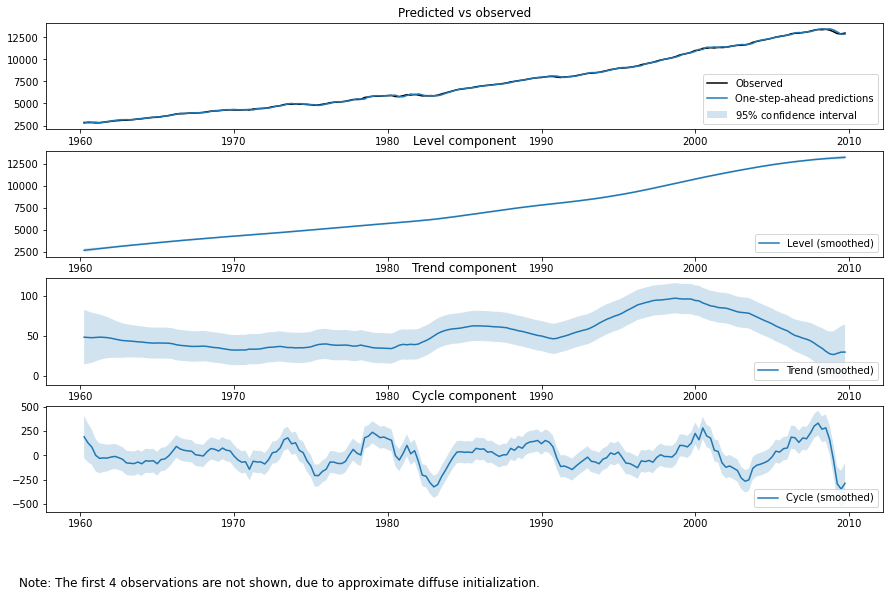

In [29]:
fig = r_res.plot_components(legend_loc='lower right', figsize=(15, 9));

In [28]:
import pandas as pd
import numpy as np
import dtw
import plotly.express as px
import plotly.graph_objects as go
import fileinput
import glob
import os

### Полезные ссылки:
1. [Что такое DTW](https://ru.wikipedia.org/wiki/Алгоритм_динамической_трансформации_временной_шкалы#/media/)
2. [Библиотека dtw, примеры использования](https://github.com/pierre-rouanet/dtw)
3. [Пример реализации KNN-DTW на нескольких наборах данных](https://nbviewer.jupyter.org/github/markdregan/K-Nearest-Neighbors-with-Dynamic-Time-Warping/blob/master/K_Nearest_Neighbor_Dynamic_Time_Warping.ipynb)

Много полезных ссылок:
https://github.com/MaxBenChrist/awesome_time_series_in_python

Кластеризация временных рядов:
https://habr.com/ru/post/334220/

In [30]:
x = np.linspace(0, 20, 100)

data = pd.DataFrame({'sin': np.sin(x),
                    'cos':(np.cos(x) + 0.5) * np.random.normal(1, 0.1, 100)})
px.line(data, facet_col_wrap=2)

In [32]:
# _,_,cost, path = dtw.dtw(data.sin, data.cos, dist = lambda x,y: (x-y)**2)

paths = ['train/X_train.txt', 'train/y_train.txt', 'test/X_test.txt', 'test/y_test.txt']

labels = {1:'WALKING', 2:'WALKING UPSTAIRS', 3:'WALKING DOWNSTAIRS',
          4:'SITTING', 5:'STANDING', 6:'LAYING'}

results = []
for path in paths:
    with open('data_seminars/uci_har/' + path, 'r') as f:
        lines = f.read().splitlines()
        lines = list(list(map(float, line.split())) for line in lines)
        results.append(np.array(lines))

x_train, y_train, x_test, y_test = results

In [33]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go



colors = ['#D62728','#2C9F2C','#FD7F23','#1F77B4','#9467BD',
          '#8C564A','#7F7F7F','#1FBECF','#E377C2','#BCBD27']

fig = make_subplots(rows=3, cols=2, subplot_titles = [labels[y_train[r][0]] for r in [0,27,65,100,145,172]])

for i, r in enumerate([0,27,65,100,145,172]):
    fig.add_trace(
    go.Scatter(y=x_train[r][:100],
               name = labels[y_train[r][0]]),
    row=(i)%3 + 1,
    col=(i)%2 + 1
    
)
    
fig.show()

In [ ]:
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from sklearn.metrics import confusion_matrix

In [47]:
cl = KNeighborsTimeSeriesClassifier(n_jobs = 3)
cl.fit(x_train, y_train)

KNeighborsTimeSeriesClassifier(n_jobs=3)

In [46]:
x_train.shape

(7352, 561)

In [48]:
preds = cl.predict(x_test)

KeyboardInterrupt: 